<a href="https://colab.research.google.com/github/Elkinmt19/data-engineer-dojo/blob/main/Ejercicio_PRAGMA_ElkinJavierGuerraGaleano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prueba práctica Científico de Datos** 



## ***Organizar el espacio de trabajo***
En primer lugar, es muy importante organizar la maquina virtual, instalando todas las dependencias necesarias para trabajar con python, al igual que traer el archivo con el dataset.



## ***Clonando el repositorio con los archivos necesarios***


In [1]:
# Clonanmos el repositorio fuente
!git clone https://github.com/Elkinmt19/data-engineer-dojo.git

Cloning into 'data-engineer-dojo'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 45 (delta 16), reused 33 (delta 8), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [2]:
# Comprobar la version de python y descargar las librerias necesarias
%cd data-engineer-dojo
!python3 --version
!pip3 install -r requirements.txt
%cd data_engineer_test


/content/data-engineer-dojo
Python 3.7.12
/content/data-engineer-dojo/data_engineer_test


## ***Se filtra el dataset para quitar el ruido***

---



In [3]:
# Ejecutando el archivo "filter_datset.py" se quita el ruido del dataset y se crea un nuevo archivo limpio
!python3 filter_dataset.py

## ***Se definen algunas librerias importantes y se obtiene la informacion del archivo .csv filtrado***


In [4]:
# Built-in imports
import os
import sys
import csv

# External imports
import numpy as np

# My Own imports
import get_path_dataset_folder as gpaf

# Get dataset folder in repo for the samples
DATASET_FOLDER = gpaf.get_dataset_folder_path()

def get_path_file(file):
    """
    This is a simple python function that gives us the absolute path of the 
    dataset's file according to the name of the file.
    """
    path_dataset_file = os.path.join(
        DATASET_FOLDER,
        file
    )

    return path_dataset_file

# Get the data from the csv file
with open(get_path_file("USvideos_clean.csv"), 'r',  encoding="utf8") as file:
        csvreader = csv.reader(file)
        features = next(csvreader)
        features = features[:11]

        rows = np.array([[None]*len(features)])

        for row in csvreader:
            rows = np.concatenate((rows,np.array([row[:11]])),axis=0)
        rows = np.delete(rows, 0, 0)

        file.close()

In [5]:
# Mostramos las variables que se pueden obtener del archivo
print(f"Tenemos {len(features)} variables")
print(features)

Tenemos 11 variables
['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count']


## ***Obtener la informacion del archivo .json***

In [6]:
# Built-in imports 
import json

# Get the data from the json file
with open(get_path_file("US_category_id.json"), "r") as read_it:
    data = json.load(read_it)
    elements = data["items"]

    features_category = ["id", "channelId", "title"]
    rows_category = []

    for it in elements:
        row_buff = [it["id"], it["snippet"]["channelId"], it["snippet"]["title"]]
        rows_category.append(row_buff)

    read_it.close()
rows_category = np.array(rows_category)
id2category = {rows_category[i,0]: rows_category[i,2] for i in range(len(rows_category[:,0]))}

In [7]:
# Mostramos las variables que se pueden obtener del archivo
print(f"Tenemos {len(features_category)} variables")
print(features_category)

Tenemos 3 variables
['id', 'channelId', 'title']


## ***Dividir el dataset en varios grupos o clusters de acuerdo a la fecha***

In [8]:
# Split the complete dataset by the trending data in order to make the analysis
clusters = np.split(
    rows,
    np.where(np.diff(np.array([x.replace('.', '') for x in rows[:,1]]).astype(int)))[0]+1
)

In [9]:
# Comprobamos que el numero de clusters sea el correcto
print(f"Se tienen {len(clusters)} dias")

Se tienen 205 dias


## ***Dividir el dataset en varios grupos o clusters de acuerdo al id de la categoria del video***

In [10]:
# Create the function tu make the video's category analysis
def category_views_likes_analysis(info_featu):
    # Split the dataset by the category_id
    elem , idxs = np.unique(info_featu[:,4], return_index=True)
    clusters = np.split(info_featu, idxs[1:])
    
    category_data = []

    for i in range(len(clusters)):
        buff = [int(elem[i]), sum(clusters[i][:,7].astype(int)), sum(clusters[i][:,8].astype(int))]
        category_data.append(buff)  

    category_data = np.array(category_data).astype(int)

    return category_data 

# Define a variable to save all the information about the category of the videos
category_data_date = []
views_max = []
likes_max = []

for dt in clusters:
  category_data_date.append(category_views_likes_analysis(dt))

for cid in category_data_date:
  # Sort the arrays by the amoung of views and likes
    view_idx = cid[:,1].argmax(axis=0)
    like_idx = cid[:,2].argmax(axis=0)

    buff_view = [cid[view_idx,0], cid[view_idx,1]]
    buff_like = [cid[like_idx,0], cid[like_idx,1]]

    views_max.append(buff_view)
    likes_max.append(buff_like)
views_max = np.array(views_max)
likes_max = np.array(likes_max)

# Get the frequency of the category_id with the max number of views and likes
unique_views, counts_views = np.unique(views_max[:,0], return_counts=True)
unique_likes, counts_likes = np.unique(likes_max[:,0], return_counts=True)
views_data_unique = np.asarray((unique_views, counts_views)).T
likes_data_unique = np.asarray((unique_likes, counts_likes)).T

## ***Graficamos algunas metricas importantes***

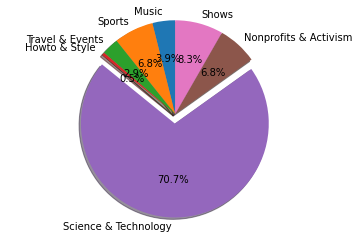

In [11]:
# External imports
import matplotlib.pyplot as plt

def greater(el, maxi):
    if (el == maxi):
        return 0.1
    return 0

# Plot the categories with more views 
labels = [id2category[str(x)] for x in views_data_unique[:,0]]
sizes = views_data_unique[:,1]
explode = [greater(x,max(views_data_unique[:,1])) for x in views_data_unique[:,1]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

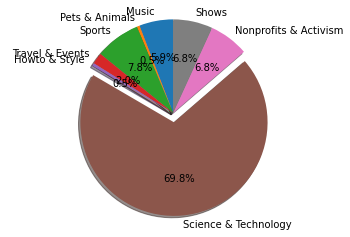

In [12]:
# Plot the categories with more likes 
labels = [id2category[str(x)] for x in likes_data_unique[:,0]]
sizes = likes_data_unique[:,1]
explode = [greater(x,max(likes_data_unique[:,1])) for x in likes_data_unique[:,1]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

## ***Preparación del dataset para el análisis correspondiente a la fecha de publicación de los videos***

In [13]:
# Split the complete dataset by the publish time in order to make the analysis
elem_publish, idxs_publish = np.unique([x[5:7] for x in rows[:,5]], return_index=True)
clusters_publish_month = np.split(rows, idxs_publish[1:])

# Define some important variables to make the analysis
mean_publish_month = []
months = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Get the average value of views by the publish month of the videos
for i in range(len(clusters_publish_month)):
    buff_array = clusters_publish_month[i]
    buff = [int(elem_publish[i]), np.mean(buff_array[:,7].astype(int))]
    mean_publish_month.append(buff)  

mean_publish_month = np.array(mean_publish_month)
mean_publish_month = mean_publish_month[mean_publish_month[:, -1] > 0]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## ***Graficamos la información resultante***

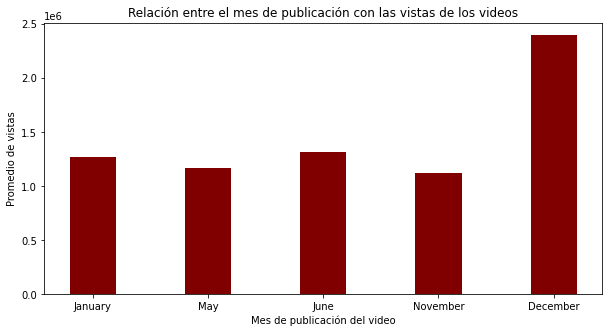

In [14]:
# Plot the results
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(
    [months[x] for x in mean_publish_month[:,0]],
    mean_publish_month[:,1],
    color ='maroon',
    width = 0.4
)
 
plt.xlabel("Mes de publicación del video")
plt.ylabel("Promedio de vistas")
plt.title("Relación entre el mes de publicación con las vistas de los videos")
plt.show()

## ***Preparar los datasets para los diferentes analisis***

In [15]:
"""
The input variables of the model are gonna be the following:
    - category_id
    - trending_day
    - trending_month
    - trending_year
    - dislikes
and the output is gonna be the variable 'likes'
"""

# Get the input's array
category_input = rows[:,4].reshape((len(rows), 1)).astype(int)
dislike_input = rows[:,9].reshape((len(rows), 1)).astype(int)

trending = rows[:,1]
day_input = np.array([int(x[6:]) for x in trending]).reshape((len(rows), 1))
month_input = np.array([int(x[3:5]) for x in trending]).reshape((len(rows), 1))
year_input = np.array([int(x[:2]) for x in trending]).reshape((len(rows), 1))

# Inputs for training the model (The regression models)
inputs = np.hstack((
    category_input,
    day_input,
    month_input,
    year_input,
    dislike_input
))

# Get the desired array in order to training the model (The regression models)
desired_views = rows[:,7].astype(int)
desired_likes = rows[:,8].astype(int)

## ***Entrenar el modelo de los likes y los views***

In [16]:
# External imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

# Build a linear regression model - views
reg_view = LinearRegression().fit(inputs, desired_views)
print("LINEAR REGRESSION MODEL INFORMATION - VIEWS")
print(f"The R^2 es: {reg_view.score(inputs, desired_views)}")
print(f"The coefficients are: {reg_view.coef_}")

# Build a linear regression model - likes
reg_like = LinearRegression().fit(inputs, desired_likes)
print("LINEAR REGRESSION MODEL INFORMATION - LIKES")
print(f"The R^2 es: {reg_like.score(inputs, desired_likes)}")
print(f"The coefficients are: {reg_like.coef_}")

LINEAR REGRESSION MODEL INFORMATION - VIEWS
The R^2 es: 0.25943848684449244
The coefficients are: [-1.41158689e+05  7.53451531e+05  2.29480497e+04  7.63962619e+06
  1.05606267e+02]
LINEAR REGRESSION MODEL INFORMATION - LIKES
The R^2 es: 0.2289389083657487
The coefficients are: [-4.64831229e+03  2.05721215e+04  6.72515425e+02  2.05843912e+05
  3.17566759e+00]


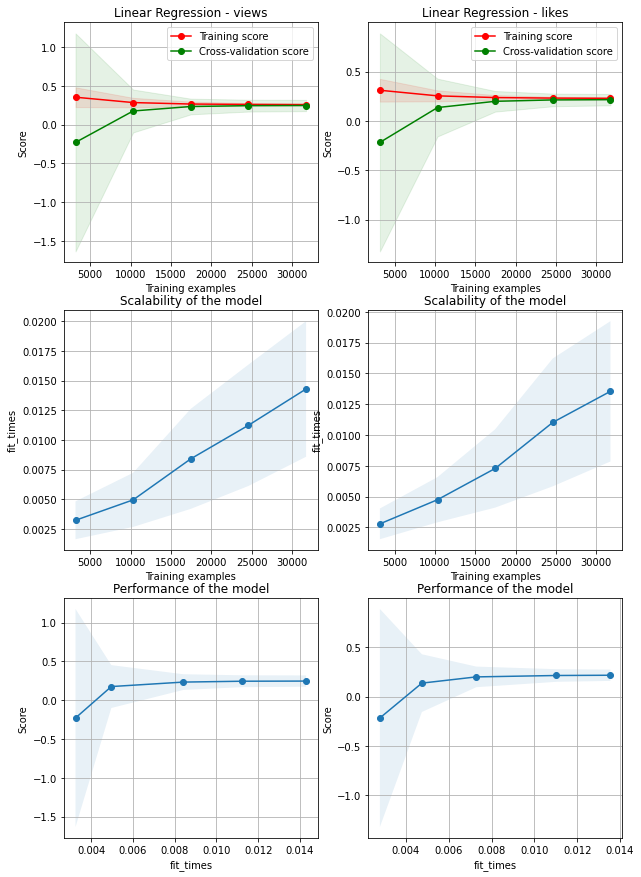

In [17]:
# External imports
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Analysis of the model (linear regression)
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# Define the variables to make the plots
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Linear Regression - views"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(
    estimator, title, inputs, desired_views, axes=axes[:, 0], cv=cv, n_jobs=4
)

title = "Linear Regression - likes"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(
    estimator, title, inputs, desired_likes, axes=axes[:, 1], cv=cv, n_jobs=4
)

plt.show()